## Load package and data

In [1]:
from upath import UPath as Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbvv

from serotiny.io.image import image_loader
from cytodata_aics.io_utils import rescale_image

20-Oct-22 14:24:24 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


In [2]:
!pip install monai

# Model

In [3]:
from serotiny.transforms.dataframe.transforms import split_dataframe
data_dir = "/home/aicsuser/cytodata-hackathon-base/data"

df = pd.read_csv(f"{data_dir}/mitocells.csv")
print(f'Number of cells: {len(df)}')
print(f'Number of columns: {len(df.columns)}')

Number of cells: 8179
Number of columns: 79


In [4]:
df["cell_stage"].value_counts()

M0               2000
M1M2             2000
M4M5             2000
M6M7_complete    1198
M3                981
Name: cell_stage, dtype: int64

In [5]:
import os
os.chdir("/home/aicsuser/cytodata-hackathon-base")

In [6]:
from datetime import datetime

# util to avoid referring to the same run unintentionally
now_str = lambda : datetime.now().strftime("%Y%m%d_%H%M%S")

# Load and train

In [7]:
run_name = f"teamx_bfdnamembrane_zproj_{now_str()}"
print(run_name)

!serotiny train \
    model=vae_2d_3ch \
    data=vae_dataloader_2d_3ch \
    mlflow.experiment_name=vae_3ch \
    mlflow.run_name={run_name} \
    trainer.gpus=[0] \
    trainer.max_epochs=30

teamx_bfdnamembrane_zproj_20221020_142441
[2022-10-20 14:24:45,203][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-10-20 14:24:45,204][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-10-20 14:24:48,254][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
[2022-10-20 14:24:48,309][pytorch_lightning.utilities.rank_zero][INFO] - GPU available: True, used: True
[2022-10-20 14:24:48,310][pytorch_lightning.utilities.rank_zero][INFO] - TPU available: False, using: 0 TPU cores
[2022-10-20 14:24:48,310][pytorch_lightning.utilities.rank_zero][INFO] - IPU available: False, using: 0 IPUs
[2022-10-20 14:24:48,310][pytorch_lightning.utilities.rank_zero][INFO] - HPU available: False, using: 0 HPUs
[2022-10-20 14:24:48,310][serotiny.ml_ops.ml_ops][INFO] - Instantiating model
[2022-10-20 14:24:48,339][serotiny.networks.basic_cnn.basic_cnn][INFO] - Determined 'compressed size': 41496 for CNN
[2022-10-20 14:24:49,282][serotiny.networks.basic_cnn.basic_cnn][INFO] - 

In [ ]:
!serotiny test \
    model=vae_2d_3ch \
    data=vae_dataloader_2d_3ch \
    mlflow.experiment_name=vae_3ch \
    mlflow.run_name="teamx_bfdnamembrane_zproj_20221020_142441" \
    trainer/callbacks=vae \
    ++force=True

[2022-10-20 17:25:42,945][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-10-20 17:25:42,946][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-10-20 17:25:46,049][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
[2022-10-20 17:25:47,787][pytorch_lightning.utilities.rank_zero][INFO] - GPU available: True, used: False
[2022-10-20 17:25:47,787][pytorch_lightning.utilities.rank_zero][INFO] - TPU available: False, using: 0 TPU cores
[2022-10-20 17:25:47,788][pytorch_lightning.utilities.rank_zero][INFO] - IPU available: False, using: 0 IPUs
[2022-10-20 17:25:47,788][pytorch_lightning.utilities.rank_zero][INFO] - HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1812:

# Extract latent space

In [75]:
run_name="teamx_bfdnamembrane_zproj_20221020_044209"
import mlflow
from serotiny.ml_ops.mlflow_utils import download_artifact

mlflow.set_tracking_uri("http://mlflow.mlflow.svc.cluster.local")

with download_artifact("dataframes/embeddings.csv", experiment_name="vae_3ch", run_name=run_name) as path:
    embeddings = pd.read_csv(path)
    
with download_artifact("dataframes/stats_per_dim_test.csv", experiment_name="vae_3ch", run_name=run_name) as path:
    kl_per_dimension = pd.read_csv(path)
    

/opt/conda/lib/python3.10/site-packages/serotiny/ml_ops/mlflow_utils.py:144: FutureWarning: ``mlflow.tracking.fluent.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  for _experiment in mlflow.list_experiments():
/opt/conda/lib/python3.10/site-packages/mlflow/tracking/fluent.py:1066: FutureWarning: ``mlflow.tracking.client.MlflowClient.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  return MlflowClient().list_experiments(
/opt/conda/lib/python3.10/site-packages/serotiny/ml_ops/mlflow_utils.py:156: FutureWarning: ``mlflow.tracking.fluent.list_run_infos`` is deprecated. This method will be removed in a future release. Use ``search_runs()`` instead.
  for run_info in mlflow.list_run_infos(experiment_id=experiment_id):
/opt/conda/lib/python3.10/site-packages/mlflow/tracking/fluent.py:1599: FutureWarning: ``mlflow.tracking.client.MlflowClient.li

In [58]:
# Get dimension ranks based on KLD values
from cytodata_aics.vae_utils import get_ranked_dims
ranked_z_dim_list, mu_std_list, mu_mean_list = get_ranked_dims(kl_per_dimension, 0, 8)

In [59]:
ranked_z_dim_list = [f"mu_{i}" for i in ranked_z_dim_list]
updated_ranks = [f"mu_{i+1}" for i in range(8)]
embeddings = embeddings[[i for i in embeddings.columns if i in ranked_z_dim_list] + ['CellId']]

In [60]:
# Rank embeddings from 1 to 8
rename_cols = {}
for i, j in zip(ranked_z_dim_list, updated_ranks):
    rename_cols[i] = j
embeddings.rename(columns = rename_cols, inplace=True)
embeddings = embeddings.reindex(sorted(embeddings.columns), axis=1)

In [61]:
embeddings = embeddings.merge(df[['CellId'] + [i for i in df.columns if "shape_mode" in i] + ['nuclear_volume', 'nuclear_height', 'nuclear_surface_area']], on = 'CellId')

<AxesSubplot: >

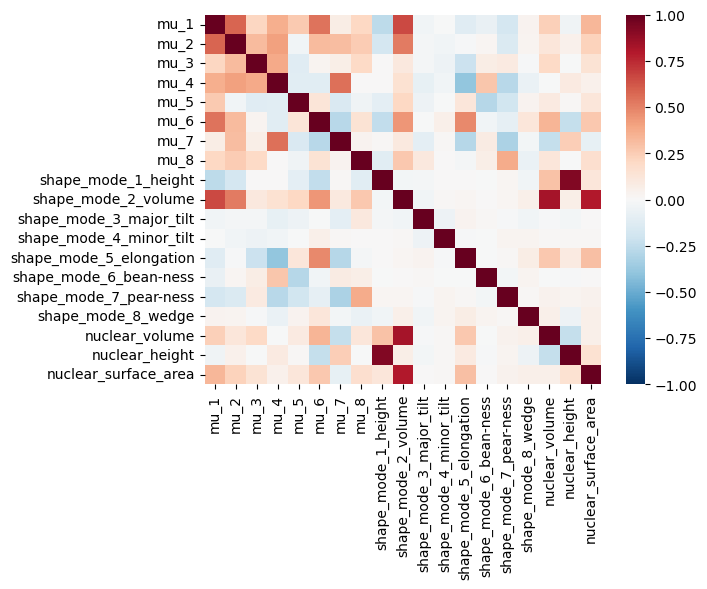

In [62]:
# Make correlation heatmap
sns.heatmap(embeddings[[i for i in embeddings.columns if i != 'CellId']].corr(), vmin=-1, vmax=1, cmap='RdBu_r')

In [65]:
!pip install scanpy
!pip install leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.0 MB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 87.4 MB/s eta 0:00:00:00:01


In [66]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [87]:
data = df.merge(embeddings, on="CellId")
data_sub = data.filter(like='mu', axis=1)
# Convert data to AnnData
obj = sc.AnnData(data_sub)

obj.obs['cell_stage'] = data['cell_stage'].values
obj.obs['CellId'] = data['CellId'].values
obj.obs['volume'] = data['shape_mode_2_volume'].values

# Scale
#sc.pp(obj)

/tmp/ipykernel_21481/4019466257.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  obj = sc.AnnData(data_sub)
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [90]:
# calculate neighborhood graph
sc.pp.neighbors(obj, n_pcs=0)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


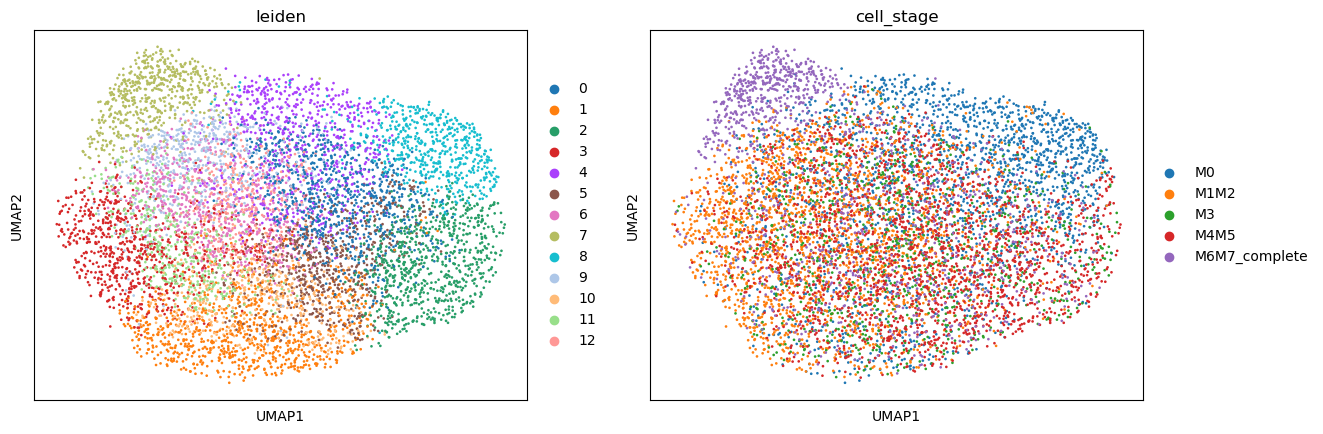

In [91]:
# Plot UMAP
sc.tl.leiden(obj)
sc.tl.umap(obj)
sc.pl.umap(obj, color=['leiden','cell_stage'])

In [92]:
obj.obs['nc_ratio'] = data['nuclear_volume'].values / data['cell_volume'].values

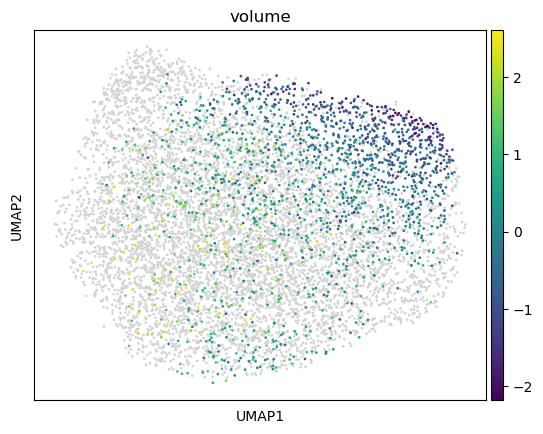

In [93]:
sc.pl.umap(obj, color='volume')